**Time Series Forecasting**

This notebook presents a data science pipeline for exploring the CORD-19 dataset, which contains rich metadata on scientific publications related to COVID-19 and related coronaviruses. The workflow focuses on both text similarity and time series forecasting. It utilizes a pre-trained SentenceTransformer model (all-MiniLM-L6-v2) to generate semantic embeddings from a combined text field composed of titles, abstracts, and author names. These embeddings are clustered using KMeans to group semantically similar papers into ten thematic clusters, with their distribution visualized via Seaborn. To uncover publication trends over time, the notebook also extracts the publication month and begins aggregating monthly publication counts. For interpretability, it displays representative paper titles from each cluster.

In [29]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

# For Clustering / Similarity Analysis
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# For Trend Analysis / Time Series Forecasting
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

# For Citation Prediction / Popularity Forecasting (Regression)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fuzzywuzzy import fuzz, process

import spacy


In [30]:
# ---------------------------
# 1. Load and Preprocess Metadata
# ---------------------------
df = pd.read_csv("metadata.csv", low_memory=False)
# Convert publish_time to datetime; drop rows with invalid dates
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df = df.dropna(subset=['publish_time'])

In [31]:
# Create a combined text field for clustering (using title, abstract and authors)
def combine_text(row):
    parts = []
    if pd.notnull(row['title']):
        parts.append(str(row['title']))
    if pd.notnull(row['abstract']):
        parts.append(str(row['abstract']))
    if pd.notnull(row['authors']):
        parts.append(str(row['authors']))
    return " ".join(parts)

df['combined_text'] = df.apply(combine_text, axis=1)


Batches: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s]


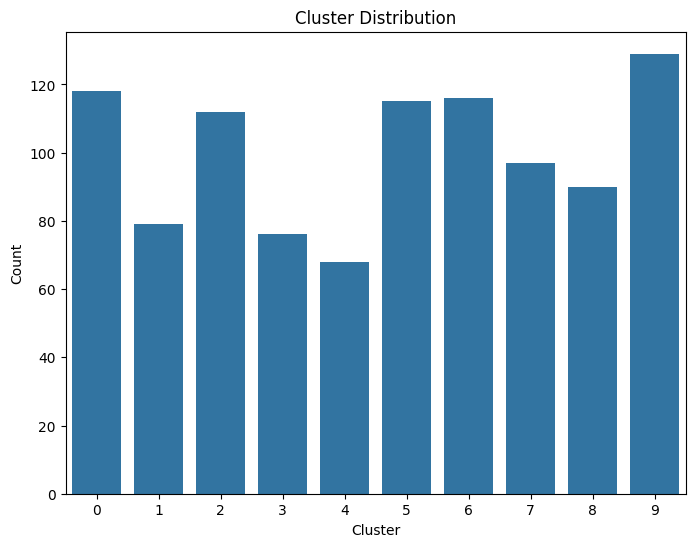


Cluster 0 sample titles:
['First isolation of Clostridium perfringens type E from a goat with diarrhea', 'Neoadjuvant Treatment Options in Soft Tissue Sarcomas', 'Application of the International System for Reporting Serous Fluid Cytopathology with Cytohistological Correlation and Risk of Malignancy Assessment']

Cluster 1 sample titles:
['Asthma in children: mapping the literature by bibliometric analysis', 'Joseph Sung: marking the tenth anniversary of SARS', "Panama's gender-based lockdown and the resilience of transgender activism: An interview with Pau González of Hombres Trans Panamá."]

Cluster 2 sample titles:
['Antibody-dependent enhancement (ADE) of SARS-CoV-2 pseudoviral infection requires FcγRIIB and virus-antibody complex with bivalent interaction', 'The impact of receptor-binding domain natural mutations on antibody recognition of SARS-CoV-2', 'Mesenchymal stem cell immunomodulation: In pursuit of controlling COVID‐19 related cytokine storm']

Cluster 3 sample titles:
['

In [32]:
# ---------------------------
# 2. Clustering / Similarity Analysis
# Goal: Group similar papers by text content (title, abstract, authors)
# ---------------------------

# Using a pre-trained SentenceTransformer (e.g., all-MiniLM-L6-v2)
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# For speed, sample a subset (e.g., 1000 papers)
sample_df = df.sample(n=1000, random_state=42) if len(df) > 1000 else df
corpus = sample_df['combined_text'].tolist()
embeddings = embedder.encode(corpus, show_progress_bar=True)

# Cluster the embeddings using KMeans (choose number of clusters, e.g., 10)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
sample_df['cluster'] = cluster_labels

# Visualize cluster distribution
plt.figure(figsize=(8,6))
sns.countplot(x='cluster', data=sample_df)
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Optionally, print sample titles per cluster
for i in range(num_clusters):
    print(f"\nCluster {i} sample titles:")
    print(sample_df[sample_df['cluster']==i]['title'].head(3).tolist())


In [33]:
# Prepare time series data
df['month'] = df['publish_time'].dt.to_period('M').dt.to_timestamp()
ts = df.groupby('month').size().reset_index(name='count')
ts.set_index('month', inplace=True)


01:28:46 - cmdstanpy - INFO - Chain [1] start processing
01:28:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


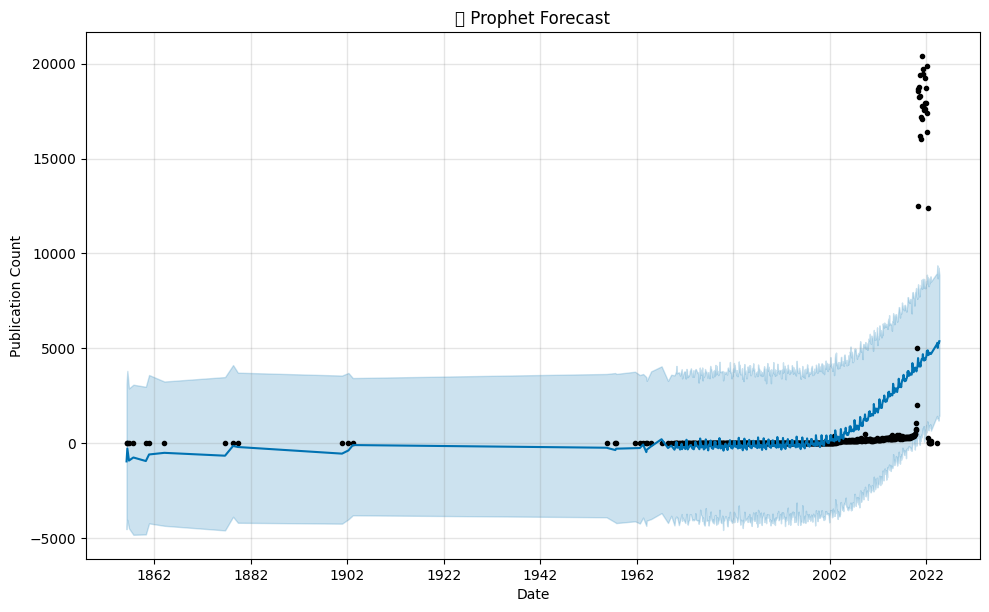

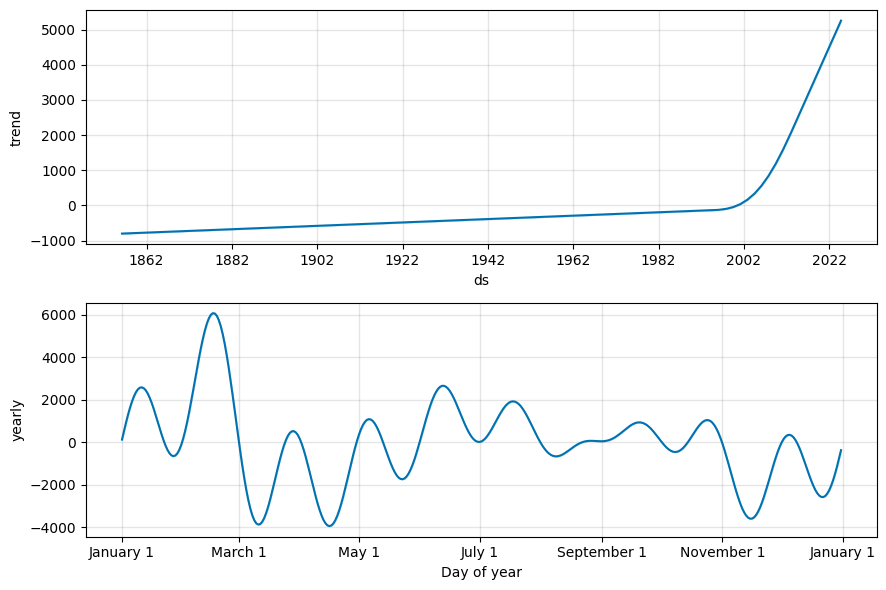

In [34]:
# ---------------------------
# Prophet Forecast
# ---------------------------
prophet_df = ts.reset_index().rename(columns={'month': 'ds', 'count': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)

fig = prophet_model.plot(forecast)
plt.title("📈 Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.show()

fig = prophet_model.plot_components(forecast)
plt.show()


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

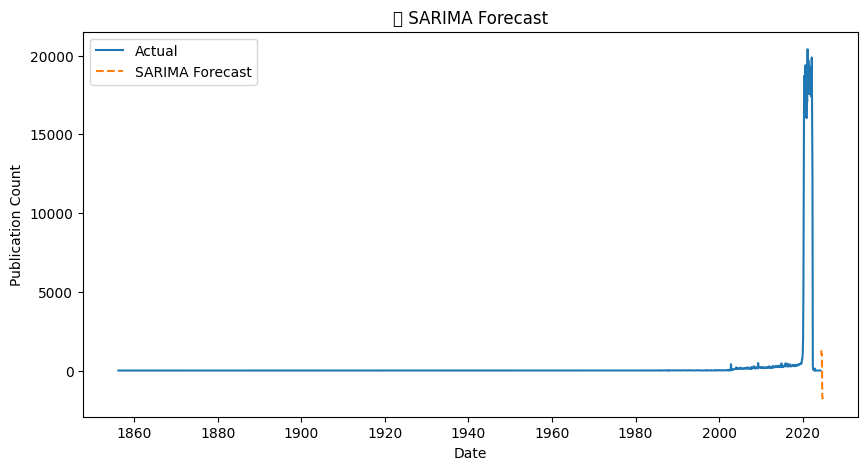

In [35]:

# ---------------------------
# SARIMA Forecast (Seasonal ARIMA)
# ---------------------------
sarima_model = SARIMAX(ts['count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=6)

plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label="Actual")
plt.plot(pd.date_range(ts.index[-1], periods=7, freq="M")[1:], sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.title("📉 SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()

C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will 

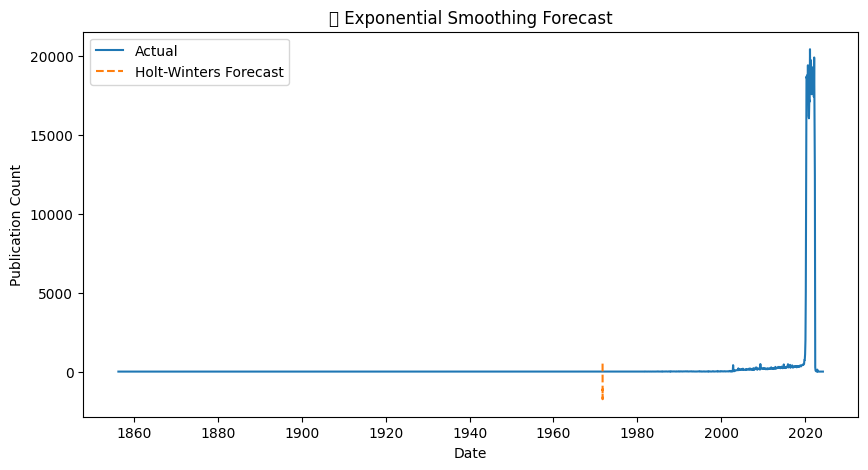

In [36]:


# ---------------------------
# Exponential Smoothing Forecast (Holt-Winters)
# ---------------------------
hw_model = ExponentialSmoothing(ts['count'], trend="add", seasonal="add", seasonal_periods=12)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(6)

plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label="Actual")
plt.plot(hw_forecast.index, hw_forecast.values, label="Holt-Winters Forecast", linestyle="--")
plt.title("🧮 Exponential Smoothing Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()

C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9963.001, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9889.254, Time=0.13 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9904.131, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9961.002, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=9894.994, Time=0.02 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=9889.163, Time=0.50 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=9890.636, Time=1.92 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=9888.776, Time=0.50 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=9888.344, Time=0.19 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=9889.095, Time=0.46 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=9891.090, Time=0.66 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=9955.656, Time=0.13 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=9886.176, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=9889.055, Time=0.07 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=9887.065, Time=0.75 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=9887.369, Time=0.58 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=9886.631, Time=0.23 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=9889.365, Time=0.71 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=9873.740, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=9871.968, Time=0.08 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=9873.763, Time=0.30 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(4,1,0)(0,0,0)[12] intercept   : AIC=9870.554, Time=0.10 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=9872.228, Time=0.38 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[12] intercept   : AIC=9872.182, Time=0.31 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(5,1,0)(0,0,0)[12] intercept   : AIC=9871.987, Time=0.12 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[12] intercept   : AIC=9872.435, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=9872.072, Time=0.20 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[12] intercept   : AIC=9868.056, Time=0.48 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,0)[12] intercept   : AIC=9870.056, Time=1.11 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[12] intercept   : AIC=9870.055, Time=0.95 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[12] intercept   : AIC=9871.501, Time=2.29 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.39 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.16 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[12]             : AIC=9866.056, Time=0.28 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,0)[12]             : AIC=9868.056, Time=0.50 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[12]             : AIC=9868.055, Time=0.47 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[12]             : AIC=9869.501, Time=1.54 sec
 ARIMA(4,1,1)(0,0,0)[12]             : AIC=9870.435, Time=0.14 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[12]             : AIC=9869.987, Time=0.57 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(4,1,0)(0,0,0)[12]             : AIC=9868.554, Time=0.09 sec


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[12]             : AIC=inf, Time=0.73 sec

Best model:  ARIMA(5,1,1)(0,0,0)[12]          
Total fit time: 26.482 seconds


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


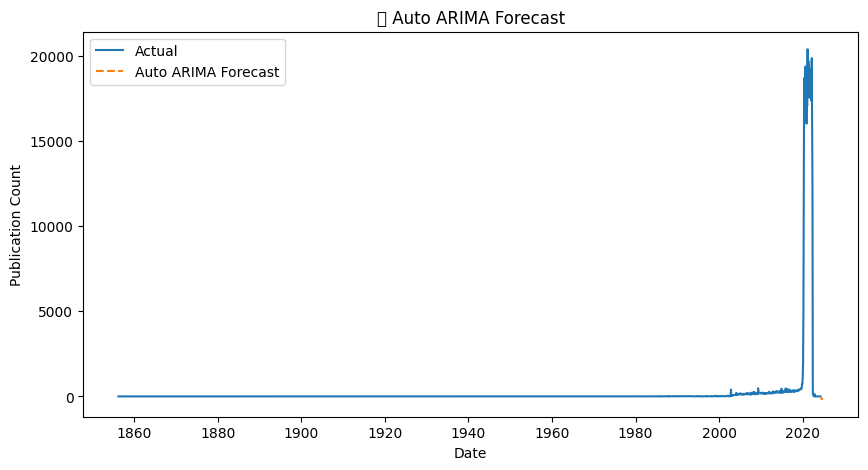

In [37]:
from pmdarima import auto_arima

# Auto ARIMA (needs pip install pmdarima)
auto_model = auto_arima(ts['count'], seasonal=True, m=12, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True)
auto_forecast = auto_model.predict(n_periods=6)

# Plot Auto ARIMA
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label="Actual")
plt.plot(pd.date_range(ts.index[-1], periods=7, freq="M")[1:], auto_forecast, label="Auto ARIMA Forecast", linestyle="--")
plt.title("🔄 Auto ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()



C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Mubashir\AppData\Local\Temp\ipykernel_17808\34825579.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=ts.index[-1], periods=7, freq="M")[1:]
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


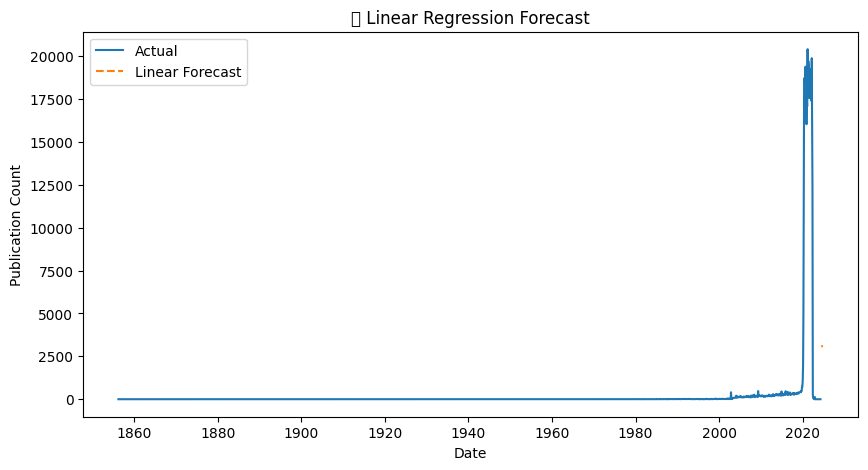

In [38]:
from sklearn.linear_model import LinearRegression

# Create a time index
ts_lr = ts.reset_index()
ts_lr['time_index'] = np.arange(len(ts_lr))

# Train-test split
X = ts_lr[['time_index']]
y = ts_lr['count']
model = LinearRegression().fit(X, y)

# Forecast for next 6 months
future_idx = np.arange(len(ts_lr), len(ts_lr) + 6).reshape(-1, 1)
lr_forecast = model.predict(future_idx)

# Plot Linear Regression Forecast
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label="Actual")
future_dates = pd.date_range(start=ts.index[-1], periods=7, freq="M")[1:]
plt.plot(future_dates, lr_forecast, label="Linear Forecast", linestyle="--")
plt.title("📐 Linear Regression Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()


C:\Users\Mubashir\AppData\Local\Temp\ipykernel_17808\1311020318.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_rf = pd.date_range(start=ts.index[-1], periods=7, freq='M')[1:]
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


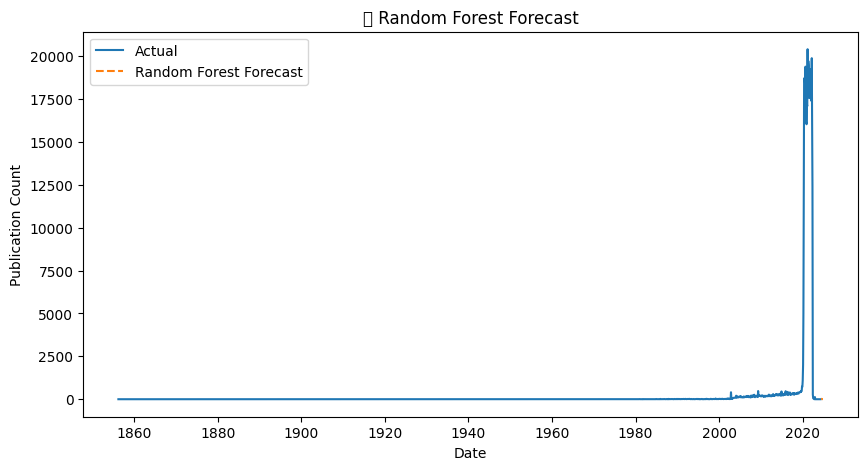

In [39]:
from sklearn.ensemble import RandomForestRegressor

# Feature engineering
ts_rf = ts.reset_index()
ts_rf['year'] = ts_rf['month'].dt.year  # extract year first
ts_rf['month'] = ts_rf['month'].dt.month  # then extract month
ts_rf['time_index'] = np.arange(len(ts_rf))


X = ts_rf[['month', 'year', 'time_index']]
y = ts_rf['count']

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Forecast next 6 months
future_rf = pd.date_range(start=ts.index[-1], periods=7, freq='M')[1:]
future_df = pd.DataFrame({
    'month': future_rf.month,
    'year': future_rf.year,
    'time_index': np.arange(len(ts_rf), len(ts_rf) + 6)
})
rf_forecast = rf_model.predict(future_df)

# Plot Random Forest Forecast
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label='Actual')
plt.plot(future_rf, rf_forecast, label='Random Forest Forecast', linestyle='--')
plt.title("🌲 Random Forest Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()


In [40]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# Reset index to have time series in proper format
ts_dl = ts.copy().reset_index()
ts_dl['count'] = ts_dl['count'].astype(float)

# Normalize values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_dl[['count']])

# Create sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

# Reshape for LSTM/GRU input: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [41]:
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, y, epochs=100, verbose=0)


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\Mubashir\AppData\Local\Temp\ipykernel_17808\3342018312.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(ts.index[-1], periods=7, freq="M")[1:]
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


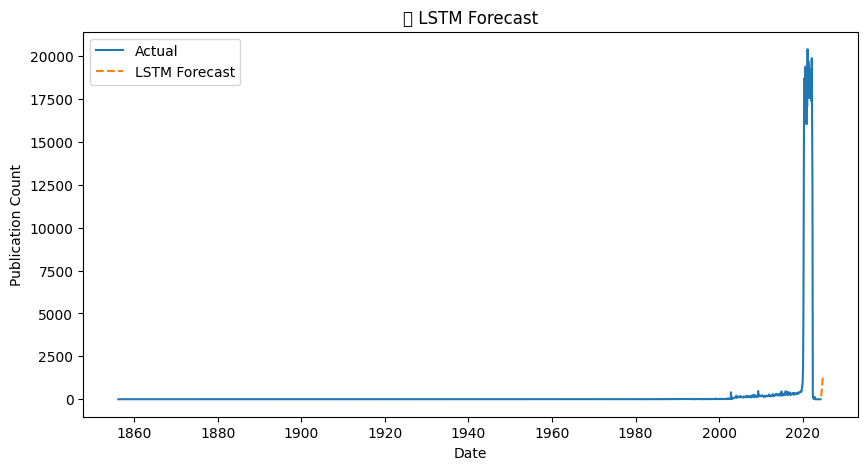

In [42]:
# Start with last sequence
last_seq = scaled_data[-seq_length:]
future_preds = []

current_seq = last_seq.reshape(1, seq_length, 1)
for _ in range(6):
    pred = lstm_model.predict(current_seq, verbose=0)[0][0]
    future_preds.append(pred)
    current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)

# Inverse transform
lstm_forecast = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Plot
future_dates = pd.date_range(ts.index[-1], periods=7, freq="M")[1:]
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label="Actual")
plt.plot(future_dates, lstm_forecast, label="LSTM Forecast", linestyle="--")
plt.title("🧠 LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


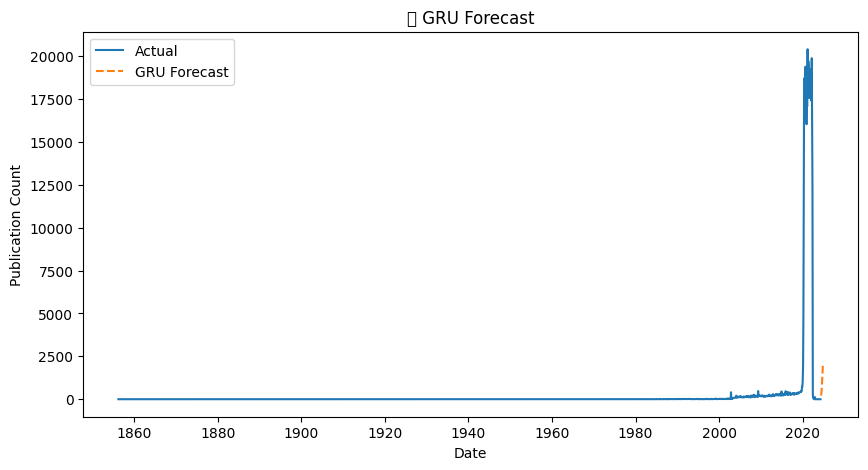

In [43]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X, y, epochs=100, verbose=0)

# Forecast with GRU
current_seq = last_seq.reshape(1, seq_length, 1)
gru_preds = []
for _ in range(6):
    pred = gru_model.predict(current_seq, verbose=0)[0][0]
    gru_preds.append(pred)
    current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)

gru_forecast = scaler.inverse_transform(np.array(gru_preds).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label="Actual")
plt.plot(future_dates, gru_forecast, label="GRU Forecast", linestyle="--")
plt.title("🧠 GRU Forecast")
plt.xlabel("Date")
plt.ylabel("Publication Count")
plt.legend()
plt.show()


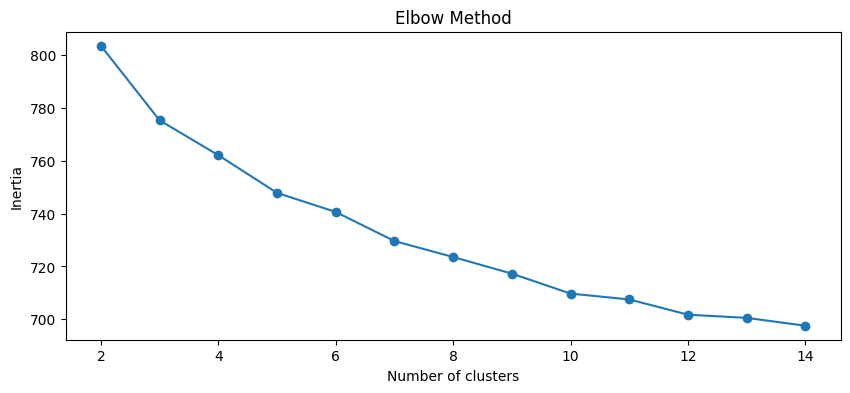

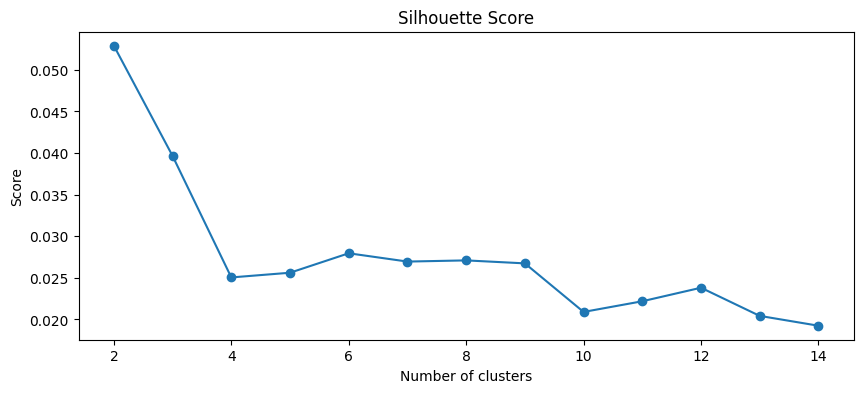

In [44]:
from sklearn.metrics import silhouette_score

# Compute inertia and silhouette for different k
inertias = []
sil_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(embeddings, labels))

# Plot Elbow
plt.figure(figsize=(10, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Plot Silhouette
plt.figure(figsize=(10, 4))
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.show()


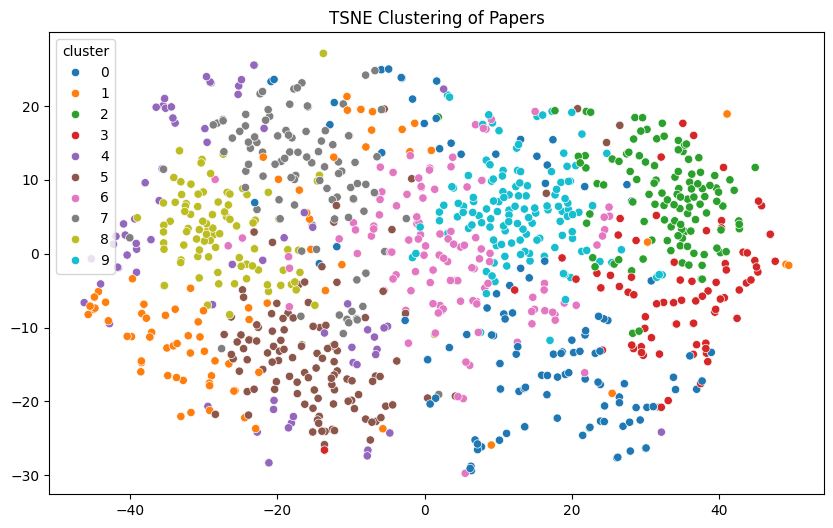

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=sample_df['cluster'], palette="tab10", legend='full')
plt.title("TSNE Clustering of Papers")
plt.show()


In [46]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

for cluster_id in range(num_clusters):
    texts = sample_df[sample_df['cluster'] == cluster_id]['combined_text'].str.lower().str.cat(sep=' ')
    words = re.findall(r'\b\w{4,}\b', texts)
    filtered = [w for w in words if w not in stop_words]
    common = Counter(filtered).most_common(10)
    print(f"\n🔍 Cluster {cluster_id} Top Terms: {[term for term, _ in common]}")



🔍 Cluster 0 Top Terms: ['patients', 'study', 'treatment', 'review', 'clinical', 'results', 'infections', 'risk', 'studies', 'high']

🔍 Cluster 1 Top Terms: ['research', 'study', 'covid', 'child', 'mass', 'disasters', 'challenges', 'black', 'fishery', 'environmental']

🔍 Cluster 2 Top Terms: ['sars', 'virus', 'covid', 'viral', 'protein', 'cells', 'spike', 'coronavirus', 'vaccine', 'infection']

🔍 Cluster 3 Top Terms: ['cells', 'cell', 'expression', 'associated', 'induced', 'human', 'immune', 'tumor', 'proteins', 'gene']

🔍 Cluster 4 Top Terms: ['data', 'learning', 'based', 'study', 'using', 'different', 'model', 'system', 'results', 'method']

🔍 Cluster 5 Top Terms: ['covid', 'pandemic', 'health', 'data', 'model', 'control', 'disease', 'cases', 'study', 'based']

🔍 Cluster 6 Top Terms: ['covid', 'patients', '2020', 'pandemic', 'study', 'mortality', 'clinical', '2019', 'risk', 'disease']

🔍 Cluster 7 Top Terms: ['patients', 'care', 'covid', 'health', 'pandemic', 'study', 'data', 'result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mubashir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_forecast(true, pred, model_name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print(f"\n📊 {model_name} Forecast Accuracy:")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

# Split the time series: last 6 months for testing
split_date = ts.index[-6]
train_ts = ts[ts.index < split_date]
test_ts = ts[ts.index >= split_date]

# Prepare training data for Prophet
prophet_train = train_ts.reset_index().rename(columns={'month': 'ds', 'count': 'y'})

# Fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Forecast next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)

# Align Prophet output with test data
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.to_period('M').dt.to_timestamp()

# test_ts.index should already be a DatetimeIndex — ensure same format
test_ts.index = test_ts.index.normalize()  # aligns to start of day

# Use only dates common to both
common_dates = test_ts.index.intersection(forecast['ds'])

# Extract predictions and true values
y_true = test_ts.loc[common_dates, 'count'].values
y_pred = forecast.set_index('ds').loc[common_dates, 'yhat'].values

# Evaluate
evaluate_forecast(y_true, y_pred, "Prophet")


01:29:56 - cmdstanpy - INFO - Chain [1] start processing
01:29:57 - cmdstanpy - INFO - Chain [1] done processing



📊 Prophet Forecast Accuracy:
RMSE: 5250.95 | MAE: 5242.89 | MAPE: 161996.80%


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [48]:
# Batch encoding large corpus
def batch_encode(texts, batch_size=64):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = embedder.encode(batch, show_progress_bar=False)
        all_embeddings.extend(emb)
    return np.array(all_embeddings)

# Full dataset embedding
embeddings = batch_encode(df['combined_text'].tolist())


C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Mubashir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


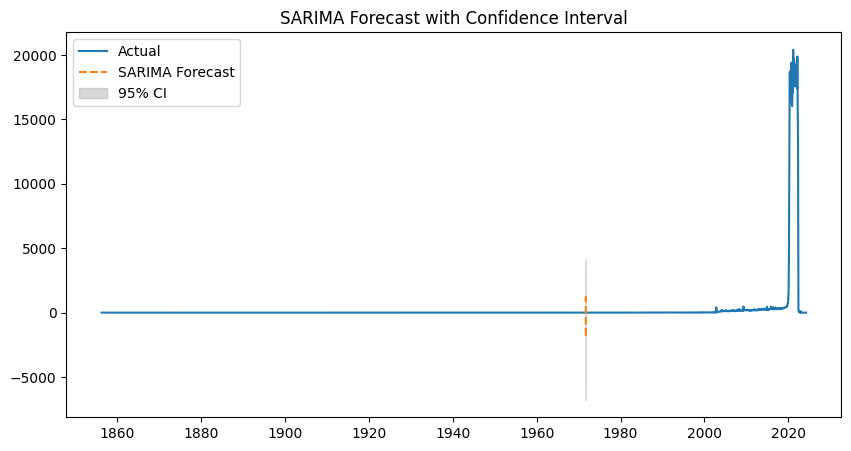

In [49]:
pred = sarima_fit.get_forecast(steps=6)
pred_mean = pred.predicted_mean
ci = pred.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['count'], label='Actual')
plt.plot(pred_mean.index, pred_mean.values, label='SARIMA Forecast', linestyle='--')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')
plt.title("SARIMA Forecast with Confidence Interval")
plt.legend()
plt.show()
